## Deep Dive concept in : Estimate the best possible coefficients for linear regression using OLS Regression

* statistical T-test
* Feature selection-Forward feature selecttion,RFE, and comparision
* Interaction Effects and Polynomial in Multiple linear Regression
* Multicollinearity
* Diagostics for Leverage and Influence,Though we have many outliers instead of discarding all outliers,only removing outliers
  which have high influation value
* Removal of Influential outliers
* compare the model results with R-square,AIC/BIC
* scaling centering and standardization
* LinearRegression model
* OLS Regresion Result Interpretation

Data Set Characteristics:**  
    :Number of Instances: 506 
    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.
    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        - Target     Median value of owner-occupied homes in $1000's
    :Missing Attribute Values: None

In [2]:
import pandas as pd
import numpy as np
import itertools
from itertools import chain, combinations
import statsmodels.formula.api as sm
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
import math
import time

In [3]:
import pandas as pd
from sklearn.datasets import load_boston
boston= load_boston()

#Create analytical data set
#Create dataframe from feature_names
boston_features_df = pd.DataFrame(data=boston.data,columns=boston.feature_names)
boston_features_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [4]:
boston_features_df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [5]:
# t-test 
from scipy import stats
col=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT']
for i in col:
    print('{}'.format(i),stats.ttest_ind(a=boston_features_df[i],b=boston.target).pvalue)


CRIM 4.1376062901253735e-168
ZN 1.3371484673796902e-22
INDUS 3.640810773418731e-90
CHAS 1.4651540072350996e-305
NOX 1.6249099761951157e-298
RM 6.49016750007408e-208
AGE 3.209461972506852e-176
DIS 2.0336282784913355e-241
RAD 7.311699727262356e-95
TAX 3.6130627946973324e-284
PTRATIO 2.332589698522123e-21
B 0.0
LSTAT 1.3813199136997922e-69


In [6]:
boston_features_df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [7]:
boston_features_df.shape

(506, 13)

#### Feature Selection
* Discuss feature selection methods available in Sci-Kit (sklearn.feature_selection), including cross-validated Recursive Feature Elimination (RFECV) and Univariate Feature Selection (SelectBest);

* Discuss methods that can inherently be used to select regressors, such as Lasso and Decision Trees - Embedded Models (SelectFromModel); 

* Demonstrate forward and backward feature selection methods using statsmodels.api; and

* Correlation coefficients as feature selection tool

### Goal: 
* variable selection has two conflicting goals: 
* (a) on the one hand, we try to include as many regressors as possible so that we can maximize the explanatory power of our model,
* (b) on the other hand, we want as few predictors as possible because more regressors could lead to an increased variance in the prediction

#### Approach:
* Dealing with large feature set, deleting some of them,  often results in a model with better precision. This is not surprising because when we retain variables with zero coefficients or coefficients with values less than their standard errors, the parameter estimates and the predicted response increase unreasonably.  However, deleting variables could also increase bias into estimates of the coefficients and the response.  Fortunately, we can find a point where the deletion of variables has a small impact, and the error (MSE) associated with parameter estimates will be smaller than the reduction in variance

#### Metrics to use when evaluating what to keep or discard:
* R squared will always increase with the addition of newer regressors.  Adjusted R squared is a metric that does not necessarily increase with the addition of variables. It only increases if the partial F statistic used to test the significance of additional regressors is greater than 1. Other metrics may also be used such as Residual Mean Square, Mallow’s Cp statistic, AIC and BIC, metrics that evaluate model error on the training dataset in machine learning.

#### Methods to evaluate what to keep or discard:
* Stepwise Feature selection
* Univariate Feature Selection-f-regression and mutual_info_regression(continuous dependent variable)
* Recursive feature elemination -RFE,RFECV
* Feature Selection Using Shrinkage (Lasso(l1)) or Decision Trees:



In [13]:
from sklearn.model_selection import train_test_split
target=pd.DataFrame(boston.target,columns=['target'])
df=pd.concat([boston_features_df,target],axis=1)
df_x=df.drop(['target'],axis=1)
df_y=df['target']
X_train,X_test,y_train,y_test=train_test_split(df_x,df_y,test_size=0.2,random_state=42)

In [14]:
# Here we uses both Forward feature selection and Backword feature selection for comparision
from sklearn.feature_selection import RFE# backward selection
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

model = LinearRegression()
#Define RFE by using linear regression model and number of features to be selected
rfe = RFE(model, 5)
#Use RFE to select the top 5 features 
fit = rfe.fit(X_train, y_train)


E:\Program Files (x86)\Anaconda Phyton\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_features_to_select=5 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [15]:
#Create a dataframe for the RFE results 
df_RFE_results = []
for i in range(df_x.shape[1]):
    df_RFE_results.append(
        {      
            'Feature_names': df_x.columns[i],
            'Selected':  rfe.support_[i],
            'RFE_ranking':  rfe.ranking_[i],
        }
    )

df_RFE_results = pd.DataFrame(df_RFE_results)
df_RFE_results.index.name='Columns'
print("Selected 5 features using RFE")
df_RFE_results

Selected 5 features using RFE


,Feature_names,Selected,RFE_ranking
Columns,,,
0,CRIM,False,3
1,ZN,False,6
2,INDUS,False,5
3,CHAS,True,1
4,NOX,True,1
5,RM,True,1
6,AGE,False,9
7,DIS,True,1
8,RAD,False,4


In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

#Define Sequential Floating Forward Selection (sffs)
sffs = SFS(LinearRegression(),
           k_features=5,
           forward=True,
           floating=True,
           scoring = 'r2',
           cv = 0)
#Use SFFS to select the top 5 features 
feature_names=df_x.columns
sffs.fit(df_x, df_y, custom_feature_names=feature_names)

SequentialFeatureSelector(cv=0, estimator=LinearRegression(), floating=True,
                          k_features=5, scoring='r2')

In [17]:
df_SFFS_results = pd.DataFrame(sffs.subsets_).transpose()
df_SFFS_results #.info()

,feature_idx,cv_scores,avg_score,feature_names
1,"(12,)",[0.5441462975864797],0.544146,"(LSTAT,)"
2,"(5, 12)",[0.6385616062603403],0.638562,"(RM, LSTAT)"
3,"(5, 10, 12)",[0.6786241601613111],0.678624,"(RM, PTRATIO, LSTAT)"
4,"(5, 7, 10, 12)",[0.6903077016842538],0.690308,"(RM, DIS, PTRATIO, LSTAT)"
5,"(4, 5, 7, 10, 12)",[0.7080892893529662],0.708089,"(NOX, RM, DIS, PTRATIO, LSTAT)"


In [33]:


#Partition the data
#Create training and test datasets
#We know from prior work that two variables were not significant contributors and need to be removed (AGE and INDUS)
# Drop AGE and INDUS
df_features=df_x.drop(columns=['CRIM',      'ZN',   'INDUS',    'CHAS', 'AGE',    'RAD',    'PTRATIO',])

#Partition dataset
import sklearn
from sklearn.model_selection import train_test_split #sklearn import does not automatically install sub packages



X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(df_features, df_y, test_size = 0.20, random_state = 5)

#For demonstration
from statsmodels.formula.api import ols

#Model statistics
model1 = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model1 = model1.summary()
print(print_model1)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     132.4
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           1.70e-91
Time:                        14:44:04   Log-Likelihood:                -1250.8
No. Observations:                 404   AIC:                             2516.
Df Residuals:                     397   BIC:                             2544.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.3886      4.897      1.305      0.1

## Interaction Effects and Polynomials in Multiple Linear Regression

* Explain what polynomial and interaction effects are in OLS regression

* Demonstrate how to automatically create polynomial and interaction terms 

* Examine whether interaction effects need to be added to a multiple OLS model

* Gauge the effect of adding interaction and polynomial effects to OLS regression

In [34]:
# Create interaction terms (interaction of each regressor pair + polynomial)
#Interaction terms need to be created in both the test and train datasets
from sklearn.preprocessing import PolynomialFeatures
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)
interaction
#traning
X_inter = pd.DataFrame(interaction.fit_transform(X_train), columns=interaction.get_feature_names(input_features=df_features.columns))
X_inter.head(3)

#test
X_inter_t = pd.DataFrame(interaction.fit_transform(X_test), columns=interaction.get_feature_names(input_features=df_features.columns))
X_inter_t.head(3)

#######################
#create the alternate for dropping all interaction terms Except the first one (the 13th variable in this case)
#This will be used in a loop where the 13th item will be replaced by the 14th, 15th...104th

#train X
X_inter_alt = X_inter.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
print(X_inter_alt.head(3))
print('')
print('')
print('')

#test X
X_inter_t_alt = X_inter_t.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]
X_inter_t_alt.head()

#######################

#Since X_inter is used in regression, the index of the that dataset and the outcome variable must be the same
#The index of X_inter was reset during the computation
#Reset the index of Y manually as well
Y_inter=Y_train.reset_index()
Y_inter=Y_inter.drop(['index'], axis=1)
print(Y_inter.head(3))

     NOX     RM     DIS    TAX       B  LSTAT     NOX^2    NOX RM   NOX DIS  \
0  0.538  5.701  3.7872  307.0  358.77  18.35  0.289444  3.067138  2.037514   
1  0.401  7.923  5.8850  198.0  395.52   3.16  0.160801  3.177123  2.359885   
2  0.679  5.957  1.8026  666.0   16.45  20.62  0.461041  4.044803  1.223965   

   NOX TAX      NOX B  NOX LSTAT       RM^2     RM DIS  
0  165.166  193.01826    9.87230  32.501401  21.590827  
1   79.398  158.60352    1.26716  62.773929  46.626855  
2  452.214   11.16955   14.00098  35.485849  10.738088  



   target
0    13.1
1    50.0
2     8.8


In [35]:
#print adjusted r squared for each model
#1. Create new datasets where the 13th item changes
#2. print all adjusted r squared stats
numbers=[]
for i in range(13,27):
        X_inter_alt2 = X_inter.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, i]]
        #X_inter_t_alt2 = X_inter.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, i]] #turned it off - we'd need it if we used stats on test data

        model3 = sm.OLS(Y_inter, sm.add_constant(X_inter_alt2)).fit()
        #Y_pred = model3.predict(sm.add_constant(X_inter_t_alt2)) #turned it off, we do not need predictions on test data
        print_model3 = model3.summary()
        #print(print_model3)

        #print(model3.rsquared_adj)

        numbers.append(model3.rsquared_adj)
    
print(numbers)

#place the array into a data frame
numbers_df=pd.DataFrame(numbers)
numbers_df.head()

[0.7597011601622721, 0.7655960025468587, 0.759676101380227, 0.773385440792813, 0.7601030417345456, 0.7600572919360145, 0.7595529602572301, 0.77284157231543, 0.7642014356883211, 0.7595249981102967, 0.7709835332115563, 0.7616391429165257, 0.7623564941415969, 0.7844687706026578]


,0
0,0.759701
1,0.765596
2,0.759676
3,0.773385
4,0.760103


In [36]:
#Concatenate the names signifying the 13th variable added to a model with adjusted r squared for each resulting model
#Get row names for all interaction and polynomial features
#first, drop all features that are not interaction or polynomial features
names=X_inter[['NOX^2', 'NOX RM', 'NOX DIS','NOX TAX', 'NOX B', 'NOX LSTAT', 'RM^2', 'RM DIS', 'RM TAX', 'RM B',
                 'RM LSTAT', 'DIS^2', 'DIS TAX', 'DIS B', 'DIS LSTAT', 'TAX^2', 'TAX B',
                      'TAX LSTAT', 'B^2', 'B LSTAT', 'LSTAT^2']]
col_heads=pd.DataFrame(list(names))
col_heads

#concatenate col_heads and numbers_df
output=pd.concat([col_heads, numbers_df.reset_index(drop=True)], axis=1)
output.head()

#give columns names otherwise sorting is not possible (by= needs a name to sort on)
output.columns=['names', 'rsquared_adj']
#output.shape

#sort by adjusted r squared: look for items with larger  values
output_sort=output.sort_values(by=['rsquared_adj'],ascending=True)
output_sort.dropna()

,names,rsquared_adj
9,RM B,0.759525
6,RM^2,0.759553
2,NOX DIS,0.759676
0,NOX^2,0.759701
5,NOX LSTAT,0.760057
4,NOX B,0.760103
11,DIS^2,0.761639
12,DIS TAX,0.762356
8,RM TAX,0.764201
1,NOX RM,0.765596


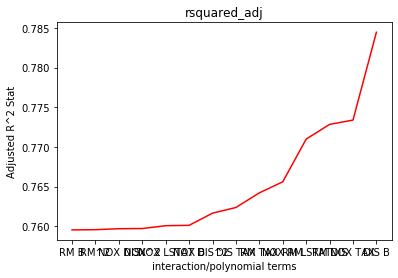

In [37]:
from pylab import *
x = output_sort.dropna()
x_=x['names']
y = x['rsquared_adj']

figure()
plot(x_,y, 'r')
xlabel('interaction/polynomial terms')
ylabel('Adjusted R^2 Stat')
title('rsquared_adj')
show()

This graph shows adjusted rsquare drops untill 0.775. note that original adjusted R square of the model without interaction was 0.73,therefore it is worth considering terms that resulted in adjusted r2 above 0.775

In [38]:
#Select columns with approprite interactions from prior analysis
#X_inter has all variables, polynomials and interactions
selected_df=X_inter[['NOX', 'RM', 'DIS', 'TAX', 'B', 'LSTAT', 'NOX^2', 'NOX RM', 'NOX DIS',
       'NOX TAX', 'NOX B', 'NOX LSTAT', 'RM^2', 'RM DIS', 'RM TAX', 'RM B',
       'RM LSTAT', 'DIS^2', 'DIS TAX', 'DIS B', 'DIS LSTAT', 'TAX^2', 'TAX B',
       'TAX LSTAT', 'B^2', 'B LSTAT', 'LSTAT^2']]

#Fit model with new dataset stored in selected_df
import statsmodels.api as sm

model = sm.OLS(Y_inter, sm.add_constant(selected_df)).fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     79.64
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          9.64e-138
Time:                        14:46:03   Log-Likelihood:                -1088.0
No. Observations:                 404   AIC:                             2232.
Df Residuals:                     376   BIC:                             2344.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -115.6022     47.783     -2.419      0.0

From above p-value we can say some variables have to interaction effect , TAX B,DIS B,DIS^2,DIS TAX,RM DIS,NOX^2,NOX RM ,NOX DIS ,NOX TAX,NOX B,NOX LSTAT,RM^2. But, we will retain all these interaction for study purpose

#### The overall adjusted R squared increased to 0.84, and the AIC/BIC both decreased compared to a model without interactions.  The original model’s AIC and BIC was 2516 and 2544 respectively.  So now the real work can start by sorting out multicollinearity and play with the model for a better fit and improved accuracy.  Still, it seems that introducing interaction and polynomial terms was really worth the effort.

## Multicollinearity

* check whether the selected feature in interaction with other variable has multicollinearity

In [39]:
# use dataset which has no interaction
from statsmodels.stats.outliers_influence import variance_inflation_factor

x_temp = sm.add_constant(df_x)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

    VIF Factor features
0        585.3    const
1          1.8     CRIM
2          2.3       ZN
3          4.0    INDUS
4          1.1     CHAS
5          4.4      NOX
6          1.9       RM
7          3.1      AGE
8          4.0      DIS
9          7.5      RAD
10         9.0      TAX
11         1.8  PTRATIO
12         1.3        B
13         2.9    LSTAT


In [40]:
# drop RAD variable
df_xcopy=df_x.copy()
df_x_postmulti=df_xcopy.drop(['RAD'],axis=1)
x_temp = sm.add_constant(df_x_postmulti)

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_temp.values, i) for i in range(x_temp.values.shape[1])]
vif["features"] = x_temp.columns
print(vif.round(1))

    VIF Factor features
0        537.9    const
1          1.7     CRIM
2          2.3       ZN
3          3.7    INDUS
4          1.1     CHAS
5          4.3      NOX
6          1.9       RM
7          3.1      AGE
8          4.0      DIS
9          3.4      TAX
10         1.7  PTRATIO
11         1.3        B
12         2.9    LSTAT


In the following code I dropped RAD.  Normally, one could start dropping the regressor with the highest VIF.  I did start with removing TAX but realized that removing that regressor made the error of the model higher and removing RAD was a much better choice.  First, we can observe that removal of RAD fixes all issues with high VIFs

In [41]:
df_original=df_x.copy()
Xo_train, Xo_test, Yo_train, Yo_test = sklearn.model_selection.train_test_split(df_original, df_y, test_size = 0.20, random_state = 5)

df_postmulti=df_x.drop(['RAD'],axis=1)
X1_train, X1_test, Y1_train, Y1_test = sklearn.model_selection.train_test_split(df_postmulti, df_y, test_size = 0.20, random_state = 5)

In [42]:
import sklearn
from sklearn import metrics


model_1 = sm.OLS(Y1_train, sm.add_constant(X1_train)).fit()
Y_pred_1 = model_1.predict(sm.add_constant(X1_test))
print_model1 = model1.summary()

model_o = sm.OLS(Yo_train, sm.add_constant(Xo_train)).fit()
Y_pred_o = model_o.predict(sm.add_constant(Xo_test))
print_model_o = model_o.summary()

print('Mean Absolute Error ( Base):', metrics.mean_absolute_error(Yo_test, Y_pred_o))  
print('')
print('Mean Absolute Error (Not collinear):', metrics.mean_absolute_error(Y1_test, Y_pred_1)) 

print("\nWithout Multicollinear variables\n",print_model1)
print("\nWith Multicollinear variables\n",print_model_o)

Mean Absolute Error ( Base): 3.2132704958423894

Mean Absolute Error (Not collinear): 3.1398352911129934

Without Multicollinear variables
                             OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     132.4
Date:                Mon, 15 Feb 2021   Prob (F-statistic):           1.70e-91
Time:                        14:46:48   Log-Likelihood:                -1250.8
No. Observations:                 404   AIC:                             2516.
Df Residuals:                     397   BIC:                             2544.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025    

In [44]:
# R-adjusted square for interaction effect on polynomials (variables selected through forward feature selection ) 


model2 = sm.OLS(Y_inter, sm.add_constant(selected_df)).fit()
print_model2 = model2.summary()
print("Without Multicollinear variables and Forward feature selection technique\n",print_model2)

Without Multicollinear variables and Forward feature selection technique
                             OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     79.64
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          9.64e-138
Time:                        14:48:56   Log-Likelihood:                -1088.0
No. Observations:                 404   AIC:                             2232.
Df Residuals:                     376   BIC:                             2344.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

#### Observation:
Though removal of highly correlated variable improved R-adjusted square from 0.66 to 0.73, we can also see that as a result of interraction effect when variable were combined, the model resulted in much more better R-adjusted square 0.84

### Diagnostics for Leverage and Influence


In [45]:
influence = model1.get_influence()
pd.Series(influence.hat_matrix_diag).describe()

count    404.000000
mean       0.017327
std        0.013928
min        0.004214
25%        0.008269
50%        0.012962
75%        0.020735
max        0.102465
dtype: float64

     dfb_const   dfb_NOX    dfb_RM   dfb_DIS   dfb_TAX     dfb_B  dfb_LSTAT  \
33   -0.016980  0.006994  0.012440  0.005855  0.031330  0.004910  -0.028881   
283  -0.129887 -0.043066  0.246132  0.008197 -0.042777  0.004264   0.070722   
418  -0.035463  0.008553  0.009541  0.005466 -0.002275  0.089585   0.005542   
502  -0.050362 -0.013874  0.041646  0.060114  0.061388 -0.001525   0.047154   
402   0.069527 -0.002289 -0.058629  0.002988 -0.061523 -0.064176  -0.049046   

      cooks_d  standard_resid  hat_diag  dffits_internal  student_resid  \
33   0.000527       -0.660430  0.008386        -0.060732      -0.659961   
283  0.015576        2.412808  0.018385         0.330203       2.427632   
418  0.001481       -0.499669  0.039867        -0.101818      -0.499196   
502  0.002037       -1.129692  0.011052        -0.119425      -1.130087   
402  0.002453       -1.090118  0.014241        -0.131026      -1.090377   

       dffits  
33  -0.060689  
283  0.332232  
418 -0.101721  
502 -0.119

,target,dfb_const,dfb_NOX,dfb_RM,dfb_DIS,dfb_TAX,dfb_B,dfb_LSTAT,cooks_d,standard_resid,leverage,dffits_internal,student_resid,dffits
0,24.0,-0.008682,-0.036171,0.016306,0.001454,0.027432,-0.002225,0.059179,0.001265,-1.095735,0.007324,-0.094119,-1.096013,-0.094143
1,21.6,-0.010443,0.004129,0.001507,0.001235,0.027503,-0.000290,-0.002422,0.000523,-0.867011,0.004844,-0.060487,-0.866740,-0.060468
2,34.7,-0.004476,0.002083,0.009972,-0.000150,-0.006499,-0.000482,-0.004401,0.000086,0.273065,0.007972,0.024479,0.272746,0.024450
3,33.4,-0.003781,0.006799,0.003536,0.007438,-0.005756,-0.001505,-0.006702,0.000062,0.217767,0.009129,0.020902,0.217505,0.020877
4,36.2,-0.034802,0.022693,0.039711,0.033253,-0.026549,0.001037,0.002636,0.001074,0.899657,0.009204,0.086710,0.899440,0.086689


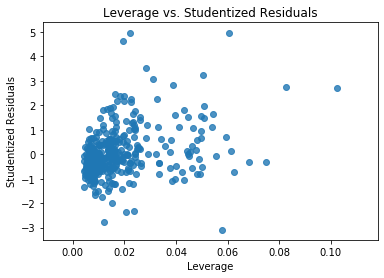

In [46]:
influence = model1.get_influence()
inf_sum = influence.summary_frame()

print(inf_sum.head())


student_resid = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag


print ('\n')
print ('Leverage vs. Studentized Residuals')
sns.regplot(leverage, model1.resid_pearson,  fit_reg=False)
plt.title('Leverage vs. Studentized Residuals')
plt.xlabel('Leverage')
plt.ylabel('Studentized Residuals')

#Concat MEDV and the resulting residual table
#Note that hat_diag is leverage so change the ciolumn heading from hat_diag to leverage
from statsmodels.formula.api import ols

Targetres = pd.concat([df_y, inf_sum], axis = 1)
Targetres=Targetres.rename(columns={'hat_diag': 'leverage'})
Targetres.head()

The next step is to identify outliers using studentized residuals.  Studentized residuals could be concerning when their absolute values exceed 2.  This is an aggressive stance and one could relax this criteria and consider studentized residuals exceeding 3 as an outlier

In [47]:
#studentized residuals for identifying outliers
#requested studentized residuals call them r
#studentized residuals that exceed +2 or -2 are concerning
#studentized residuals that exceed +3 or -3 are extremely concerning

r = Targetres.student_resid
print ('-'*30 + ' studentized residual ' + '-'*30)
print (r.describe())
print ('\n')

r_sort = Targetres.sort_values(by = 'student_resid')
print ('-'*30 + ' top 5 most negative residuals ' + '-'*30)
print (r_sort.head())
print ('\n')



------------------------------ studentized residual ------------------------------
count    404.000000
mean       0.004375
std        1.015687
min       -3.208596
25%       -0.588246
50%       -0.200188
75%        0.373283
max        5.297791
Name: student_resid, dtype: float64


------------------------------ top 5 most negative residuals ------------------------------
     target  dfb_const   dfb_NOX    dfb_RM   dfb_DIS   dfb_TAX     dfb_B  \
364    21.9   0.558557 -0.215868 -0.584933 -0.078722 -0.231739 -0.162366   
505    11.9  -0.144385 -0.057957  0.144802  0.129766  0.147415  0.005672   
380    10.4   0.195408  0.032937 -0.213384  0.052112 -0.174703 -0.176693   
375    15.0   0.201920  0.015695 -0.228140  0.061661 -0.184471 -0.165844   
401     7.2   0.129338 -0.002295 -0.101007  0.010855 -0.119926 -0.143699   

     dfb_LSTAT   cooks_d  standard_resid  leverage  dffits_internal  \
364   0.031604  0.088319       -3.171681  0.057899        -0.786277   
505   0.164939  0.013712    

In [48]:
#Print all MEDV values where the studentized residuals exceed 2
print (Targetres.target[abs(r) > 2])

148    17.8
161    50.0
162    50.0
166    50.0
195    50.0
203    48.5
204    50.0
214    23.7
267    50.0
283    50.0
364    21.9
365    27.5
367    23.1
368    50.0
369    50.0
370    50.0
371    50.0
372    50.0
374    13.8
375    15.0
380    10.4
401     7.2
505    11.9
Name: target, dtype: float64


Now that we identified outliers, we need to see which observations can be considered to have leverage values. As discussed earlier, the leverage cutoff can be calculated as (2k+2)/n where k is the number of predictors and n is the sample size

In [49]:
#Identify high leverage
#point with leverage = (2k+2)/n 
#k = number of predictors (11)
#n = number of observations (506)
((2*11)+2)/506 #=0.04743083003952569 any numbner higher than this is high leverage
l = Targetres.leverage

print ('-'*30 + ' Leverage ' + '-'*30)
print (l.describe())
print ('\n')

l_sort = Targetres.sort_values(by = 'leverage', ascending = False)
print ('-'*30 + ' top 5 highest leverage data points ' + '-'*30)
print (l_sort.head())

------------------------------ Leverage ------------------------------
count    404.000000
mean       0.017327
std        0.013928
min        0.004214
25%        0.008269
50%        0.012962
75%        0.020735
max        0.102465
Name: leverage, dtype: float64


------------------------------ top 5 highest leverage data points ------------------------------
     target  dfb_const   dfb_NOX    dfb_RM   dfb_DIS   dfb_TAX     dfb_B  \
365    27.5   0.555805  0.169854 -0.856870 -0.056675  0.184564 -0.054112   
367    23.1   0.717375 -0.124261 -0.724403 -0.193486  0.138091 -0.444089   
155    15.6   0.004940 -0.071186  0.010588 -0.029196  0.053309  0.055958   
152    15.3  -0.002291 -0.070598  0.041588 -0.023572  0.035996  0.005731   
159    23.3   0.065398 -0.179986  0.013002 -0.065509  0.075955 -0.005698   

     dfb_LSTAT   cooks_d  standard_resid  leverage  dffits_internal  \
365  -0.743238  0.132018        2.845136  0.102465         0.961314   
367  -0.517262  0.105681        2.864638

In [50]:
#point with leverage = (2k+2)/n = 0.04743083003952569
#Print all Targetres values where the leverage exceeds 0.04743083003952569
print (Targetres.target[abs(l) > ((2*11)+2)/506])

48     14.4
142    13.4
143    15.6
144    11.8
145    13.8
146    15.6
147    14.6
148    17.8
152    15.3
154    17.0
155    15.6
159    23.3
257    50.0
364    21.9
365    27.5
367    23.1
368    50.0
374    13.8
415     7.2
416     7.5
423    13.4
424    11.7
426    10.2
457    13.5
Name: target, dtype: float64


Now that we identified some outliers and leverage values, let’s bring them together to identify observations with significant influence.  Indeed, when an observation is both an outlier and has high leverage, it will surely impact the regression line as a result of influencing regression coefficients

In [51]:
#large residual and large leverage = INFLUENTIAL
#Print values that are both outliers and influential
outlier=pd.DataFrame((Targetres.target[abs(r) > 2]))
lev= pd.DataFrame((Targetres.target[abs(l) > ((2*11)+2)/506]))

#Influential1=pd.merge(outlier,lev, left_index=True, right_index=True, how='outer')
#print(Influential1)

Influential2=pd.merge(outlier,lev, left_index=True, right_index=True)
print(Influential2)

     target_x  target_y
148      17.8      17.8
364      21.9      21.9
365      27.5      27.5
367      23.1      23.1
368      50.0      50.0
374      13.8      13.8


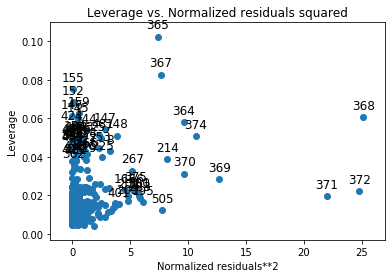

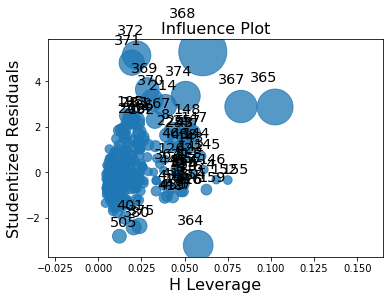

In [52]:
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(model1)
#plt.show()

# plt.scatter(MEDVres.student_resid ** 2, MEDVres.leverage)
# for i, state in enumerate(boston_df.MEDV):
#     plt.annotate(state, [(MEDVres.student_resid ** 2)[i],  MEDVres.leverage[i]])
# plt.xlabel("Normalized Residuals**2")
# plt.ylabel("Leverage")
# plt.show()

influence_plot(model1)
plt.show()

### Remove influential observations and rerun regression


1. Apply on to model with non collinear features and compare the Rsquare

In [53]:
#Remove influential observations and rerun regression
boston_alt_x=df_postmulti.drop([148,364,365,367,368,374])
boston_alt_y=df_y.drop([148,364,365,367,368,374])

In [54]:
X = boston_alt_x
Y = boston_alt_y

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.20, random_state = 5)

In [55]:
from statsmodels.formula.api import ols

model_alt = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model_alt = model_alt.summary()
print(print_model_alt)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     97.34
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          7.69e-109
Time:                        14:49:16   Log-Likelihood:                -1176.8
No. Observations:                 400   AIC:                             2380.
Df Residuals:                     387   BIC:                             2432.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.8010      5.623      3.343      0.0

### Result: Both Adjusted-R square and R-square after outlier removal improved from 0.73 to 0.75

2. The outlier is removed in Model which has interaction variable and improvement is checked with rsquare

In [56]:
#Remove influential observations and rerun regression
boston_alt_x_inter=selected_df.drop([148,364,365,367,368,374])
boston_alt_y_inter=Y_inter.drop([148,364,365,367,368,374])

In [57]:
X = boston_alt_x_inter
Y = boston_alt_y_inter

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.20, random_state = 5)


In [58]:
from statsmodels.formula.api import ols

model_alt = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model_alt = model_alt.summary()
print(print_model_alt)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     76.73
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          1.78e-115
Time:                        14:49:20   Log-Likelihood:                -824.15
No. Observations:                 318   AIC:                             1704.
Df Residuals:                     290   BIC:                             1810.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -114.9079     56.424     -2.037      0.0

### Result: Both Adjusted-R square and R-square after outlier removal improved from 0.85 to 0.87

The conclusion is that model fit can be improved by identifying and removing outliers, observations with high leverage and influential observations. Having said that, deleting observations may not be desirable and other methods may be used to deal with influential values such as using an artificial cap value or replacing all influential values with the mean.

### Standardization

In [59]:
#STANDARDIZATION #########################
#Standard Scaler
#centers data by removing the mean value then scale by dividing by standard deviation. 
#Pure centering

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df_scaled=pd.concat([boston_alt_x,boston_alt_y],axis=1)
scaled_df=pd.DataFrame(scaler.fit_transform(df_scaled), columns=df_scaled.columns)
scaled_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,target
0,-0.413165,0.277715,-1.276254,-0.270114,-0.129477,0.413989,-0.109049,0.127310,-0.655196,-1.454813,0.437476,-1.086376,0.164528
1,-0.410727,-0.491342,-0.581198,-0.270114,-0.729980,0.182950,0.377810,0.544789,-0.977806,-0.298584,0.437476,-0.494401,-0.097842
2,-0.410729,-0.491342,-0.581198,-0.270114,-0.729980,1.329143,-0.254752,0.544789,-0.977806,-0.298584,0.392835,-1.221562,1.334265
3,-0.410139,-0.491342,-1.295237,-0.270114,-0.825712,1.048596,-0.798471,1.066031,-1.097291,0.117658,0.412578,-1.376671,1.192148
4,-0.405877,-0.491342,-1.295237,-0.270114,-0.825712,1.272134,-0.499959,1.066031,-1.097291,0.117658,0.437476,-1.036570,1.498247


Text(0.5, 1.0, 'CRIM')

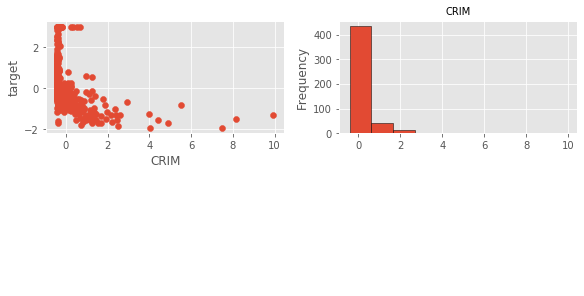

In [60]:
#Plot to demonastrate the effect of scaling on one of the variables: CRIM
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.gridspec as gridspec

fig1 = plt.figure(constrained_layout=True)
spec1 = gridspec.GridSpec(ncols=2, nrows=2, figure=fig1)



f1_ax1 = fig1.add_subplot(spec1[0, 0])
plt.scatter(scaled_df['CRIM'],scaled_df['target'])
plt.xlabel('CRIM')
plt.ylabel('target')
f2_ax2 = fig1.add_subplot(spec1[0, 1])
scaled_df['CRIM'].plot(kind='hist',edgecolor='black',figsize=(8,4))
plt.title('CRIM', size=10)



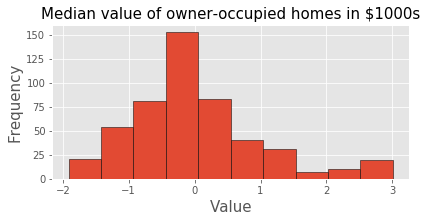

In [61]:
#Exploratory Data Analysis
import matplotlib.pyplot as plt
plt.style.use('ggplot')
# Histogram of target: price    
scaled_df['target'].plot(kind='hist',edgecolor='black',figsize=(6,3))
plt.title('Median value of owner-occupied homes in $1000s', size=15)
plt.xlabel('Value', size=15)
plt.ylabel('Frequency', size=15) 
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

E:\Program Files (x86)\Anaconda Phyton\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


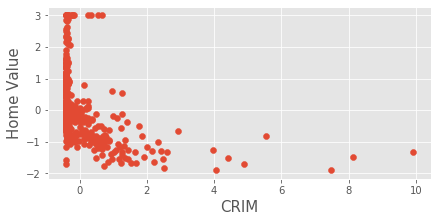

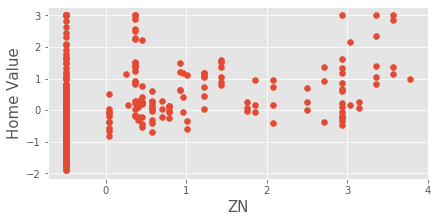

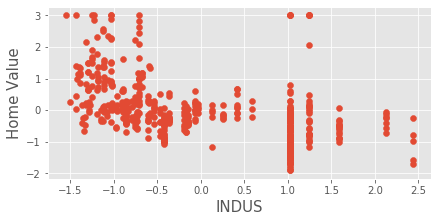

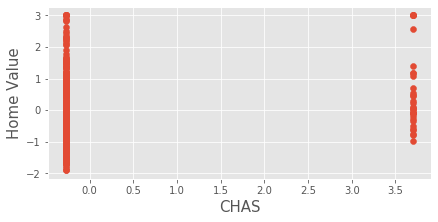

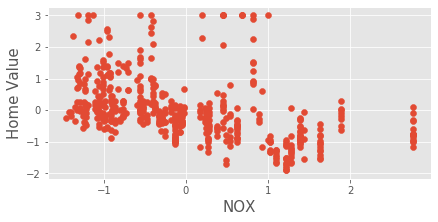

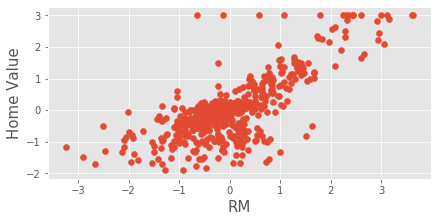

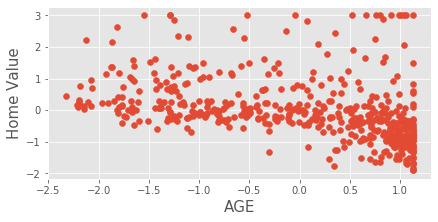

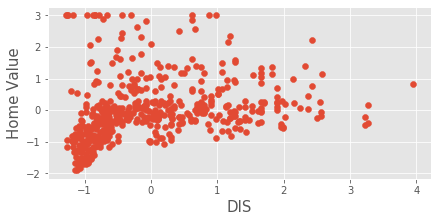

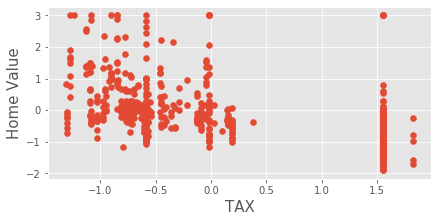

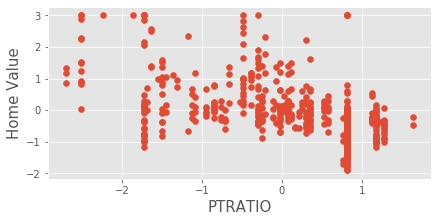

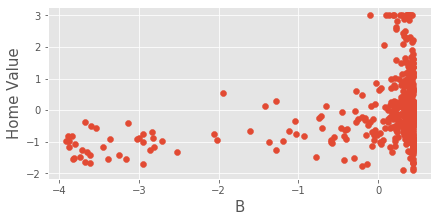

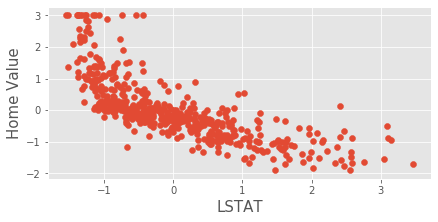

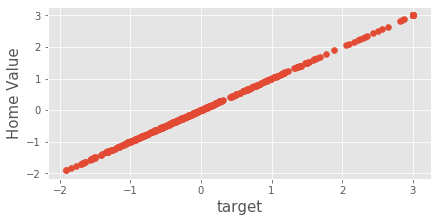

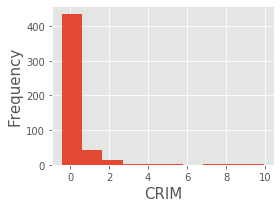

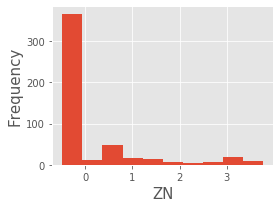

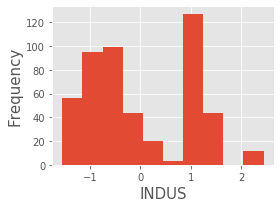

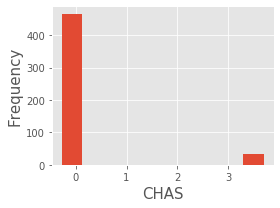

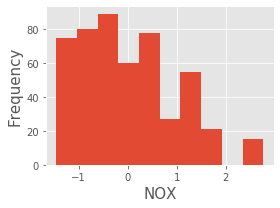

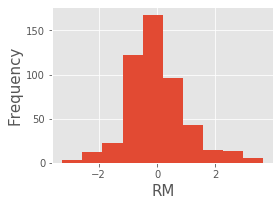

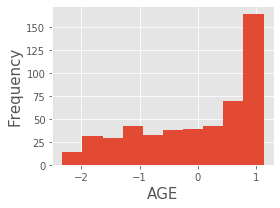

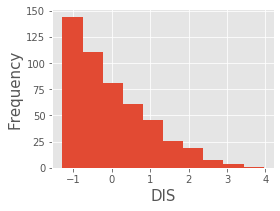

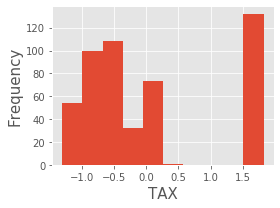

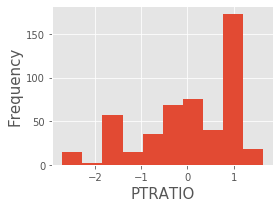

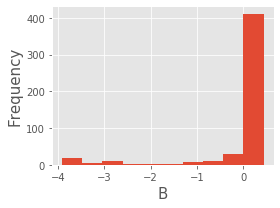

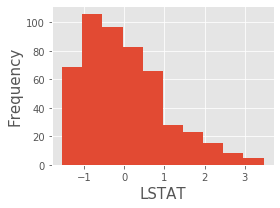

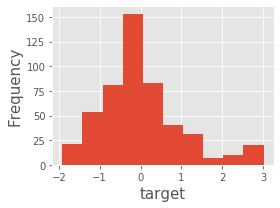

In [62]:
#Linear Relationship:  There should be a linear relationship between predictors and response variable
for index, feature_name in enumerate(scaled_df.columns):
    plt.figure(figsize=(6, 3))
    plt.scatter(scaled_df.iloc[:, index], scaled_df['target'])
    plt.ylabel('Home Value', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)   
#Assess distribution of features
for index, feature_name in enumerate(scaled_df.columns):
    plt.figure(figsize=(4, 3))
    plt.hist(scaled_df.iloc[:, index])
    plt.ylabel('Frequency', size=15)
    plt.xlabel(feature_name, size=15)
    plt.tight_layout()

Multiple plots show non-linear relationships (ZN, INDUS, NOX, LSTAT, AGE, DIS, B).  CRIM has multiple extreme observations, while observations at the 0 CRIM level have no relationship with home values. RAD and TAX has no relationship with Home values at the highest levels, certainly a cause of concern

### Regression Model

In [63]:
from sklearn import linear_model
X = scaled_df.drop('target', axis = 1)
Y = scaled_df['target'] 

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size = 0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)


(400, 12)
(100, 12)


Text(0.5, 1.0, 'Home Values: Actual vs Predicted')

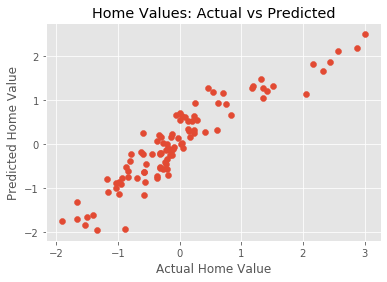

In [64]:
#Train regression model
from sklearn.linear_model import LinearRegression
lin_mod1 = LinearRegression()
lin_mod1.fit(X_train, Y_train)
#Create predictions using test features
Y_pred = lin_mod1.predict(X_test)
#Compare predicted and actual MEDV still based on train data
plt.scatter(Y_test, Y_pred)
plt.xlabel("Actual Home Value")
plt.ylabel("Predicted Home Value")
plt.title("Home Values: Actual vs Predicted")

In [65]:
#Print model parameters
print('Intercept: \n', lin_mod1.intercept_)
print('Coefficidents: \n', lin_mod1.coef_)

Intercept: 
 0.008694011661116184
Coefficidents: 
 [-0.06675247  0.06995382 -0.04540635  0.11736465 -0.16009186  0.39651279
 -0.05028605 -0.28613972  0.00256573 -0.192816    0.08448076 -0.32254537]


In [66]:
#Goodness of fit statistics: values closer to 0 are better
import sklearn
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test, Y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(Y_test, Y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))
print("r2_score",metrics.r2_score(Y_pred,Y_test))

Mean Absolute Error: 0.29174237412465137
Mean Squared Error: 0.13730004903807524
Root Mean Squared Error: 0.3705402124440413
r2_score 0.8450701503915847


In [67]:
#Model statistics
#Ensure that constant is added: represets y-intercept
model_3 = sm.OLS(Y_train, sm.add_constant(X_train)).fit()
print_model_ = model3.summary()
print(print_model_)

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.792
Model:                            OLS   Adj. R-squared:                  0.784
Method:                 Least Squares   F-statistic:                     105.8
Date:                Mon, 15 Feb 2021   Prob (F-statistic):          5.00e-123
Time:                        14:53:16   Log-Likelihood:                -1155.7
No. Observations:                 404   AIC:                             2341.
Df Residuals:                     389   BIC:                             2401.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -67.0238     32.419     -2.067      0.0

### Result interpretation:

After standard scaling finally, some very important model stats can be obtained from the OLS Regression Results table.  First, the F-statistic is large at 97, which is certainly larger than 1, which allows us to reject the null hypothesis, and conclude that at least one of the variables must be related to the target price.  The R-squared is also very large at 0.75 indicating that the model explains 75% of the variance in the target variable.  We also get two fit statistics Akaike Information Criterion and Bayesian Information Criterion, which are large but by themselves they are difficult to evaluate.  They will be useful when fitting alternative models.  

Unfortunately,when variables are fitted into regression model, we do have some variables that were not a significant contributor to the explanatory power of the model (INDUS, ZN, TAX, AGE). 

In [68]:
#RESIDUAL ANALYSIS: CHECK FIT OF TRAINED MODEL
predictions = lin_mod1.predict(X_train) #make predictions with train data/use sklearn
residual=Y_train-predictions
residual.head()

247    0.312722
390   -0.655530
186   -0.213245
484    0.106622
139    0.015853
Name: target, dtype: float64

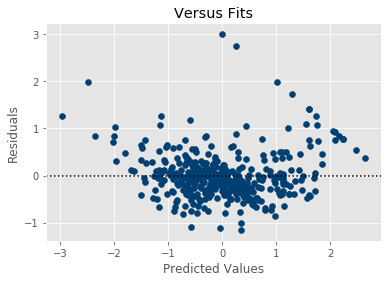

In [69]:
#RESIDUALS VS. FITS
plt.axhline(y=0, color='k', linestyle=':') #draw a black horizontal line when residuals equal 0

plt.scatter(predictions, residual, color='#003F72')
plt.title('Versus Fits')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

### Right type of regression used: 

The Versus Fits plot is also useful in determining whether the right type of regression has been used.  The curved pattern shows that the chosen regression was of the wrong type.